## Libraries

In [312]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy


## Exploratory Analysis

In [2]:
df = pd.read_csv("train.csv", index_col = 0)

In [3]:
df.shape

(80176, 13)

In [4]:
df.columns

Index(['date', 'org', 'tld', 'ccs', 'bcced', 'mail_type', 'images', 'urls',
       'salutations', 'designation', 'chars_in_subject', 'chars_in_body',
       'label'],
      dtype='object')

In [5]:
df.head()

,date,org,tld,ccs,bcced,mail_type,images,urls,salutations,designation,chars_in_subject,chars_in_body,label
0,"Mon, 6 Nov 2017 11:13:45 +0100",reply,ebay.in,0,0,multipart/alternative,35,120,0,0,49.0,80027,2
1,"Wed, 14 Feb 2018 11:00:16 -0000",edm,efinmail.com,0,0,multipart/alternative,1,7,0,0,107.0,2961,1
2,"Wed, 6 Jul 2016 19:53:37 +0000",usebackpack,com,0,0,text/html,4,17,0,0,35.0,25149,1
3,"Fri, 11 Oct 2019 11:25:40 +0200",granular,ai,0,0,multipart/mixed,0,0,0,0,15.0,635296,1
4,"Tue, 07 Nov 2017 11:07:18 +0000 (UTC)",github,com,1,0,multipart/alternative,2,11,0,0,49.0,2355,1


In [6]:
df.dtypes

date                 object
org                  object
tld                  object
ccs                   int64
bcced                 int64
mail_type            object
images                int64
urls                  int64
salutations           int64
designation           int64
chars_in_subject    float64
chars_in_body         int64
label                 int64
dtype: object

## Data Cleaning

#### Cleaning Date

In [7]:
def get_day(x):
    days = ['Mon', 'Wed', 'Fri', 'Tue', 'Sun', 'Sat', 'Thu']
    if x.split(' ')[0][:-1] in days:
        return x.split(' ')[0][:-1]
    return 'No day'
df['day'] = df['date'].apply(get_day)

def get_day_number(x):
    try:
        day_number = int(x.split(' ')[1])
        return day_number
    except:
        try:
            day_number = int(x.split(' ')[0][:-1])
            return day_number
        except:
            return -1
        
def get_month(x):
    months = ['Aug', 'Sep', 'Oct', 'Jul', 'Apr', 'Mar', 'Jan', 'Jun', 'Feb', 'May', 'Nov', 'Dec']
    try:
        if x.split(' ')[2] in months:
            return x.split(' ')[2]
        elif x.split(' ')[1] in months:
            return x.split(' ')[1]
    except:
        return 'No Month' 
    
def get_year(x):
    try:
        year = int(x.split(' ')[3])
        return year
    except:
        try: 
            year = int(x.split(' ')[2])
            if year > 2000:
                return year
            else:
                try:
                    year = int(x.split(' ')[1])
                    if year > 2000:
                        return year
                except:
                    return 0
        except:
            return 0
def get_hour(x):
    try:
        hour = int(x.split(' ')[4][:2])
        return hour
    except:
        return -1

In [8]:
df['day'] = df['date'].apply(get_day)
df['day_number'] = df['date'].apply(get_day_number)
df['month'] = df['date'].apply(get_month)
df['year'] = df['date'].apply(get_year)
df['hour'] = df['date'].apply(get_hour)

#### Cleaning ORG

In [9]:
def get_top_org(min_count = 1000):
    """Gets the mininum occurence number of an organization and 
    returns the organizations which occur more than the minimu

    Parameters
    ----------
    The minimum number of occurence for an organization
    min_count : int 

    Returns
    -------
    All the organizatinos occuring more than the minimum
    list_org : list
    """
    (df.org.value_counts() > min_count).value_counts()
    df_temp = df.groupby(['org']).count()
    df_temp[df_temp['date'] > min_count].shape
    df_temp[df_temp['date'] > min_count]['date'].sum()
    list_org = list(df_temp[df_temp['date'] > min_count].index)
    return list_org

org_list = get_top_org()

def new_org_column(x):
    global org_list
    if x in org_list:
        return x
    else:
        return 'Others'


We can see that 7 org accounts for more than half the count, this could be a parameter

In [10]:
df['top_org'] = df['org'].apply(new_org_column)

In [11]:
df['top_org']

0             Others
1             Others
2        usebackpack
3             Others
4             github
            ...     
80171         github
80172         Others
80173         google
80174         Others
80175         Others
Name: top_org, Length: 80176, dtype: object

#### clean TLD

In [12]:
def get_top_tld(min_count = 1000):
    """Gets the mininum occurence number of an organization and 
    returns the organizations which occur more than the minimuù

    Parameters
    ----------
    The minimum number of occurence for an organization
    min_count : int 

    Returns
    -------
    All the organizatinos occuring more than the minimum
    list_org : list
    """
    (df.tld.value_counts() > min_count).value_counts()
    df_temp = df.groupby(['tld']).count()
    df_temp[df_temp['date'] > min_count].shape
    df_temp[df_temp['date'] > min_count]['date'].sum()
    list_tld = list(df_temp[df_temp['date'] > min_count].index)
    return list_tld

org_list = get_top_tld(500)

def new_tld_column(x):
    global org_list
    if x in org_list:
        return x
    else:
        return 'Others'


In [13]:
df['top_tld'] = df['tld'].apply(new_tld_column)

In [14]:
df['top_tld'].value_counts()

top_tld
com            34619
ac.in          20042
Others         12576
in              3783
org             3428
fr              1580
gov.in          1540
ai               720
co.in            704
netflix.com      629
net              555
Name: count, dtype: int64

#### Clean Mail

In [15]:
df.mail_type.unique()

array(['multipart/alternative', 'text/html', 'multipart/mixed',
       'multipart/related', 'text/plain', nan, 'text/html ',
       'multipart/signed', 'Multipart/Mixed', 'Text/Html',
       'multipart/report', 'Multipart/Alternative', 'text/calendar',
       'multipart/IDM'], dtype=object)

In [16]:
def get_mail_type1(x):
    try:
        mails = x.split('/')
        mail = mails[0].lower()
        return mail
    except:
        return 'other'

def get_mail_type2(x):
    try:
        mails = x.split('/')
        mail = mails[1].lower()
        return mail
    except:
        return 'other'

In [17]:
df['mail1'] = df.mail_type.apply(get_mail_type1)
df['mail2'] = df.mail_type.apply(get_mail_type2)

In [18]:
df['mail1'].value_counts()
df['mail2'].value_counts()

mail2
alternative    58452
html           10234
mixed           6500
plain           2720
related         1996
other            172
html              58
signed            26
report            13
calendar           4
idm                1
Name: count, dtype: int64

#### Cleaning Missing values

In [19]:
df.describe()

,ccs,bcced,images,urls,salutations,designation,chars_in_subject,chars_in_body,label,day_number,year,hour
count,80176.000000,80176.000000,80176.000000,80176.000000,80176.000000,80176.000000,80160.000000,8.017600e+04,80176.000000,80176.000000,80176.000000,80176.000000
mean,0.473259,0.002869,7.875998,34.433172,0.406381,0.104246,51.535254,1.971784e+05,1.557187,14.891676,2002.465451,11.328951
std,3.178805,0.053484,305.444093,97.904682,0.491160,0.305581,33.718283,1.890130e+06,1.713352,9.080254,169.903425,6.238051
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000e+00,0.000000,-1.000000,0.000000,-1.000000
25%,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,32.000000,4.651000e+03,1.000000,7.000000,2016.000000,7.000000
50%,0.000000,0.000000,2.000000,17.000000,0.000000,0.000000,42.000000,1.999950e+04,1.000000,14.000000,2017.000000,12.000000
75%,0.000000,0.000000,8.000000,44.000000,1.000000,0.000000,62.000000,4.519300e+04,2.000000,23.000000,2018.000000,16.000000
max,179.000000,1.000000,83481.000000,21540.000000,1.000000,1.000000,606.000000,7.438108e+07,7.000000,31.000000,2020.000000,23.000000


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80176 entries, 0 to 80175
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              80176 non-null  object 
 1   org               76725 non-null  object 
 2   tld               76723 non-null  object 
 3   ccs               80176 non-null  int64  
 4   bcced             80176 non-null  int64  
 5   mail_type         80004 non-null  object 
 6   images            80176 non-null  int64  
 7   urls              80176 non-null  int64  
 8   salutations       80176 non-null  int64  
 9   designation       80176 non-null  int64  
 10  chars_in_subject  80160 non-null  float64
 11  chars_in_body     80176 non-null  int64  
 12  label             80176 non-null  int64  
 13  day               80176 non-null  object 
 14  day_number        80176 non-null  int64  
 15  month             79606 non-null  object 
 16  year              80176 non-null  int64  
 17

#### Cleaning MONTH

In [21]:
df.loc[df.month.isna(), 'month'] = 'Missing'

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80176 entries, 0 to 80175
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              80176 non-null  object 
 1   org               76725 non-null  object 
 2   tld               76723 non-null  object 
 3   ccs               80176 non-null  int64  
 4   bcced             80176 non-null  int64  
 5   mail_type         80004 non-null  object 
 6   images            80176 non-null  int64  
 7   urls              80176 non-null  int64  
 8   salutations       80176 non-null  int64  
 9   designation       80176 non-null  int64  
 10  chars_in_subject  80160 non-null  float64
 11  chars_in_body     80176 non-null  int64  
 12  label             80176 non-null  int64  
 13  day               80176 non-null  object 
 14  day_number        80176 non-null  int64  
 15  month             80176 non-null  object 
 16  year              80176 non-null  int64  
 17

#### CHARS in subject

In [23]:
df.loc[df.chars_in_subject.isna(), 'chars_in_subject'] = -1

In [24]:
df['has_subject'] = (df['chars_in_subject'] > 0).astype(int)

#### Remove the unnecessary columns

In [25]:
df = df.drop(['date','org','tld','mail_type'], axis = 1)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80176 entries, 0 to 80175
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ccs               80176 non-null  int64  
 1   bcced             80176 non-null  int64  
 2   images            80176 non-null  int64  
 3   urls              80176 non-null  int64  
 4   salutations       80176 non-null  int64  
 5   designation       80176 non-null  int64  
 6   chars_in_subject  80176 non-null  float64
 7   chars_in_body     80176 non-null  int64  
 8   label             80176 non-null  int64  
 9   day               80176 non-null  object 
 10  day_number        80176 non-null  int64  
 11  month             80176 non-null  object 
 12  year              80176 non-null  int64  
 13  hour              80176 non-null  int64  
 14  top_org           80176 non-null  object 
 15  top_tld           80176 non-null  object 
 16  mail1             80176 non-null  object 
 17

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80176 entries, 0 to 80175
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ccs               80176 non-null  int64  
 1   bcced             80176 non-null  int64  
 2   images            80176 non-null  int64  
 3   urls              80176 non-null  int64  
 4   salutations       80176 non-null  int64  
 5   designation       80176 non-null  int64  
 6   chars_in_subject  80176 non-null  float64
 7   chars_in_body     80176 non-null  int64  
 8   label             80176 non-null  int64  
 9   day               80176 non-null  object 
 10  day_number        80176 non-null  int64  
 11  month             80176 non-null  object 
 12  year              80176 non-null  int64  
 13  hour              80176 non-null  int64  
 14  top_org           80176 non-null  object 
 15  top_tld           80176 non-null  object 
 16  mail1             80176 non-null  object 
 17

In [28]:
object_columns = df.select_dtypes(include=['object']).columns

# One-hot encode object columns
df_encoded = pd.get_dummies(df, columns=object_columns)

# Display the encoded DataFrame
print(df_encoded.head())

   ccs  bcced  images  urls  salutations  designation  chars_in_subject  \
0    0      0      35   120            0            0              49.0   
1    0      0       1     7            0            0             107.0   
2    0      0       4    17            0            0              35.0   
3    0      0       0     0            0            0              15.0   
4    1      0       2    11            0            0              49.0   

   chars_in_body  label  day_number  ...  mail2_calendar  mail2_html  \
0          80027      2           6  ...           False       False   
1           2961      1          14  ...           False       False   
2          25149      1           6  ...           False        True   
3         635296      1          11  ...           False       False   
4           2355      1           7  ...           False       False   

   mail2_html   mail2_idm  mail2_mixed  mail2_other  mail2_plain  \
0        False      False        False        Fa

In [29]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80176 entries, 0 to 80175
Data columns (total 72 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ccs                  80176 non-null  int64  
 1   bcced                80176 non-null  int64  
 2   images               80176 non-null  int64  
 3   urls                 80176 non-null  int64  
 4   salutations          80176 non-null  int64  
 5   designation          80176 non-null  int64  
 6   chars_in_subject     80176 non-null  float64
 7   chars_in_body        80176 non-null  int64  
 8   label                80176 non-null  int64  
 9   day_number           80176 non-null  int64  
 10  year                 80176 non-null  int64  
 11  hour                 80176 non-null  int64  
 12  has_subject          80176 non-null  int64  
 13  day_Fri              80176 non-null  bool   
 14  day_Mon              80176 non-null  bool   
 15  day_No day           80176 non-null  bool

## Modeling

#### Apply logistic regression

In [30]:
columns_to_apply = ['ccs','images','salutations','chars_in_subject', 'urls', 'chars_in_body','day_number','year','hour']

Explanation

(array([8.0111e+04, 2.0000e+01, 9.0000e+00, 2.0000e+00, 9.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 2.3000e+01, 1.0000e+00]),
 array([  0. ,  17.9,  35.8,  53.7,  71.6,  89.5, 107.4, 125.3, 143.2,
        161.1, 179. ]),
 <BarContainer object of 10 artists>)

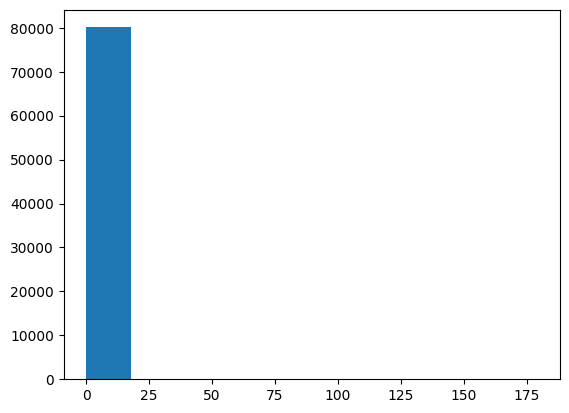

In [31]:
plt.hist(df['ccs'])

(array([6.7283e+04, 5.3640e+03, 5.0090e+03, 1.7610e+03, 5.5800e+02,
        1.5100e+02, 5.0000e+00, 9.0000e+00, 1.2000e+01, 2.4000e+01]),
 array([0.        , 0.51929569, 1.03859137, 1.55788706, 2.07718274,
        2.59647843, 3.11577411, 3.6350698 , 4.15436548, 4.67366117,
        5.19295685]),
 <BarContainer object of 10 artists>)

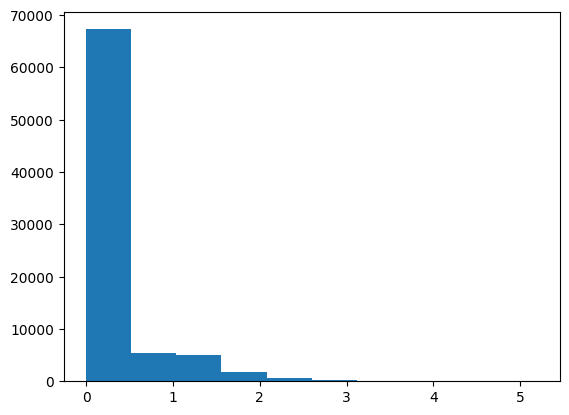

In [32]:
plt.hist(np.log(df['ccs'] + 1))

In [33]:
for column in columns_to_apply:
    df_encoded[column] = np.log(df_encoded[column] + 3)

In [34]:
df_encoded.describe()

,ccs,bcced,images,urls,salutations,designation,chars_in_subject,chars_in_body,label,day_number,year,hour,has_subject
count,80176.000000,80176.000000,80176.000000,80176.000000,80176.000000,80176.000000,80176.000000,80176.000000,80176.000000,80176.000000,80176.000000,80176.000000,80176.000000
mean,1.189882,0.002869,1.851521,2.915175,1.215521,0.104246,3.833130,9.524993,1.557187,2.713350,7.564252,2.531137,0.993564
std,0.254638,0.053484,0.818691,1.220684,0.141298,0.305581,0.598760,2.108542,1.713352,0.641947,0.548564,0.567579,0.079966
min,1.098612,0.000000,1.098612,1.098612,1.098612,0.000000,0.693147,1.945910,0.000000,0.693147,1.098612,0.693147,0.000000
25%,1.098612,0.000000,1.098612,1.945910,1.098612,0.000000,3.555348,8.445482,1.000000,2.302585,7.610358,2.302585,1.000000
50%,1.098612,0.000000,1.609438,2.995732,1.098612,0.000000,3.806662,9.903613,1.000000,2.833213,7.610853,2.708050,1.000000
75%,1.098612,0.000000,2.397895,3.850148,1.386294,0.000000,4.174387,10.718764,2.000000,3.258097,7.611348,2.944439,1.000000
max,5.204007,1.000000,11.332410,9.977806,1.386294,1.000000,6.411818,18.124712,7.000000,3.526361,7.612337,3.258097,1.000000


#### Standardize

In [35]:
""" df_standardize = df_encoded.copy()
df_standardize.drop['']
df_standardize.info()
columns_to_standardize = list(df_standardize.columns)
from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the selected columns
df_standardize[columns_to_standardize] = scaler.fit_transform(df_standardize[columns_to_standardize])
df_standardize.describe() """

" df_standardize = df_encoded.copy()\ndf_standardize.drop['']\ndf_standardize.info()\ncolumns_to_standardize = list(df_standardize.columns)\nfrom sklearn.preprocessing import StandardScaler\n\n# Initialize StandardScaler\nscaler = StandardScaler()\n\n# Fit and transform the selected columns\ndf_standardize[columns_to_standardize] = scaler.fit_transform(df_standardize[columns_to_standardize])\ndf_standardize.describe() "

In [36]:
df_encoded

,ccs,bcced,images,urls,salutations,designation,chars_in_subject,chars_in_body,label,day_number,...,mail2_calendar,mail2_html,mail2_html,mail2_idm,mail2_mixed,mail2_other,mail2_plain,mail2_related,mail2_report,mail2_signed
0,1.098612,0,3.637586,4.812184,1.098612,0,3.951244,11.290157,2,2.197225,...,False,False,False,False,False,False,False,False,False,False
1,1.098612,0,1.386294,2.302585,1.098612,0,4.700480,7.994295,1,2.833213,...,False,False,False,False,False,False,False,False,False,False
2,1.098612,0,1.945910,2.995732,1.098612,0,3.637586,10.132693,1,2.197225,...,False,True,False,False,False,False,False,False,False,False
3,1.098612,0,1.098612,1.098612,1.098612,0,2.890372,13.361851,1,2.639057,...,False,False,False,False,True,False,False,False,False,False
4,1.386294,0,1.609438,2.639057,1.098612,0,3.951244,7.765569,1,2.302585,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80171,1.386294,0,1.098612,2.397895,1.098612,0,4.543295,7.177782,3,3.496508,...,False,False,False,False,False,False,False,False,False,False
80172,1.098612,0,1.098612,1.609438,1.386294,0,4.330733,9.507998,0,0.693147,...,False,True,False,False,False,False,False,False,False,False
80173,1.098612,0,3.401197,4.477337,1.098612,0,3.891820,10.257238,0,3.367296,...,False,False,False,False,False,False,False,False,False,False
80174,1.098612,0,3.555348,5.488938,1.386294,1,5.147494,11.564369,0,2.833213,...,False,False,False,False,False,False,False,False,False,False


### Train and Test split

In [37]:
# Used for deep learning after because it doesn't want a type string
df2 = df_encoded.copy()

### Stop here for Deep learning

In [85]:
df_encoded['label'] = df_encoded['label'].values.astype('str')

In [86]:

# Assuming X contains your features and y contains your target variable
X = df_encoded.drop(columns=['label'])  # Features (excluding the target variable)
y = df_encoded['label']  # Target variable

# Splitting the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Modeling

In [87]:
y_train.unique()

array(['0', '1', '2', '3', '7', '5', '4', '6'], dtype=object)

In [42]:

# Assuming X_train, X_test, y_train, y_test are already defined from the train-test split
# Initialize logistic regression model
logistic_regression_model = LogisticRegression(max_iter = 1000)

# Train the model
logistic_regression_model.fit(X_train, y_train)

# Predict on the test data
y_pred = logistic_regression_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [43]:
accuracy

0.5361062609129459

In [44]:
classification_report(y_test, y_pred)

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'              precision    recall  f1-score   support\n\n           0       0.55      0.36      0.43      3680\n           1       0.53      0.66      0.59      7429\n           2       0.43      0.32      0.36      1719\n           3       0.59      0.51      0.55      2109\n           4       0.40      0.04      0.07        50\n           5       0.00      0.00      0.00        26\n           6       0.00      0.00      0.00        31\n           7       0.57      0.76      0.65       992\n\n    accuracy                           0.54     16036\n   macro avg       0.38      0.33      0.33     16036\nweighted avg       0.53      0.54      0.52     16036\n'

In [52]:
cm = confusion_matrix(y_test, y_pred)

In [55]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=logistic_regression_model.classes_)

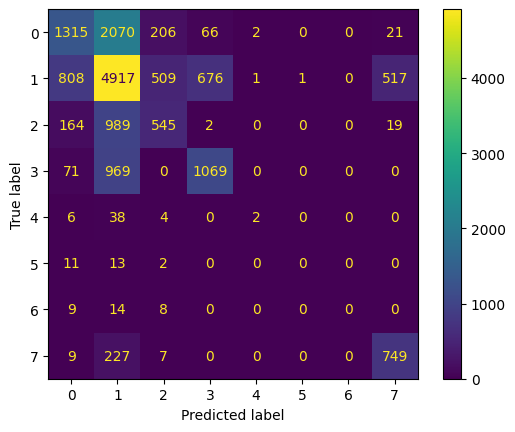

In [56]:
disp.plot()

In [57]:
y_train.value_counts()

label
1    29766
0    14315
3     8618
2     6848
7     4050
4      307
6      121
5      115
Name: count, dtype: int64

### Dealing with Imbalanced data

#### Oversampling

In [88]:
oversample = RandomOverSampler()
X_over, y_over = oversample.fit_resample(X, y)
y_over.value_counts()

label
2    37195
1    37195
3    37195
7    37195
0    37195
4    37195
6    37195
5    37195
Name: count, dtype: int64

In [86]:
def oversample_logistic(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Assuming X_train, X_test, y_train, y_test are already defined from the train-test split
    # Initialize logistic regression model
    logistic_regression_model = LogisticRegression(max_iter = 1000)

    # Train the model
    logistic_regression_model.fit(X_train, y_train)

    # Predict on the test data
    y_pred = logistic_regression_model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=logistic_regression_model.classes_)

    disp.plot()

    return y_pred, y_test

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


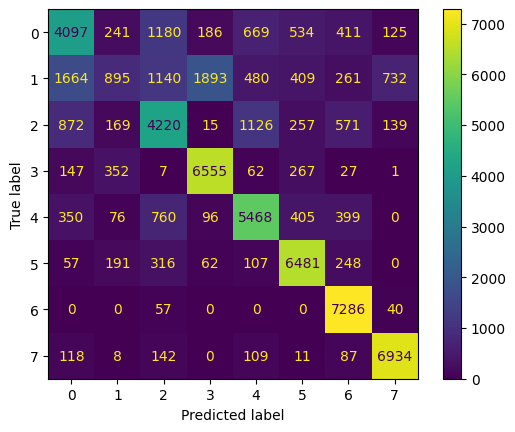

In [87]:
y_pred, y_test = oversample_logistic(X_over,y_over)

In [88]:
accuracy = accuracy_score(y_test, y_pred)
print('accuracy : ' + str(accuracy))
f1_score = f1_score(y_test, y_pred, average='weighted')
print('f1 score  : ' + str(f1_score))

accuracy : 0.7046646054577228
f1 score  : 0.6754033589388955


### No Sampling

#### Trying different Models

In [63]:

# Define a dictionary to store models
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC()
}

# Train and evaluate each model
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {name}: {accuracy:.4f}")
    
    # Additional evaluation metrics
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred))
    
    print(f"Confusion Matrix for {name}:")
    print(confusion_matrix(y_test, y_pred))
    print("\n")


    # Extract F1 score from classification report
    f1_score = classification_rep.split()[-2]

    print("F1 Score:", f1_score)



Training Logistic Regression...


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy for Logistic Regression: 0.5293
Classification Report for Logistic Regression:


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.55      0.36      0.44      3680
           1       0.53      0.66      0.59      7429
           2       0.42      0.35      0.38      1719
           3       0.58      0.52      0.55      2109
           4       0.00      0.00      0.00        50
           5       0.00      0.00      0.00        26
           6       0.00      0.00      0.00        31
           7       0.56      0.54      0.55       992

    accuracy                           0.53     16036
   macro avg       0.33      0.30      0.31     16036
weighted avg       0.53      0.53      0.52     16036

Confusion Matrix for Logistic Regression:
[[1338 2031  232   61    0    0    0   18]
 [ 816 4919  593  714    0    1    0  386]
 [ 202  894  607    3    0    0    0   13]
 [  22  994    0 1093    0    0    0    0]
 [   6   37    7    0    0    0    0    0]
 [   9   13    4    0    0    0    0    0]
 [   7   16    8    0    0    0    0    0]
 [  14

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [64]:
df_encoded['label'].value_counts()

label
1    37195
0    17995
3    10727
2     8567
7     5042
4      357
6      152
5      141
Name: count, dtype: int64

In [101]:
def oversample_multi_models(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define a dictionary to store models
    models = {
        'Logistic Regression': LogisticRegression(),
        'Decision Tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier(),
        'Support Vector Machine': SVC()
    }

    # Train and evaluate each model
    for name, model in models.items():
        print(f"Training {name}...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=logistic_regression_model.classes_)

        accuracy = accuracy_score(y_test, y_pred)
        print('accuracy : ' + str(accuracy))
        f1_value = f1_score(y_test, y_pred, average='weighted')
        print('f1 score  : ' + str(f1_value))

        disp.plot()

In [102]:
y_pred, y_test = oversample_multi_models(X_over,y_over)

Training Logistic Regression...


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy : 0.6864497916386612
f1 score  : 0.6631368996488407
Training Decision Tree...
accuracy : 0.8783102567549402
f1 score  : 0.8639599064071858
Training Random Forest...
accuracy : 0.8813012501680333
f1 score  : 0.8658276140795483
Training Support Vector Machine...


### Using Deep Learning Algorithms

In [313]:
df2 = df_encoded.copy()

No Sampling

In [314]:
bool_columns = df2.select_dtypes(include=['bool']).columns

In [315]:
bool_columns

Index(['day_Fri', 'day_Mon', 'day_No day', 'day_Sat', 'day_Sun', 'day_Thu',
       'day_Tue', 'day_Wed', 'month_Apr', 'month_Aug', 'month_Dec',
       'month_Feb', 'month_Jan', 'month_Jul', 'month_Jun', 'month_Mar',
       'month_May', 'month_Missing', 'month_No Month', 'month_Nov',
       'month_Oct', 'month_Sep', 'top_org_Others', 'top_org_amazon',
       'top_org_github', 'top_org_gmail', 'top_org_google', 'top_org_iiitd',
       'top_org_linkedin', 'top_org_nrsc', 'top_org_quora', 'top_org_twitter',
       'top_org_usebackpack', 'top_org_youtube', 'top_tld_Others',
       'top_tld_ac.in', 'top_tld_ai', 'top_tld_co.in', 'top_tld_com',
       'top_tld_fr', 'top_tld_gov.in', 'top_tld_in', 'top_tld_net',
       'top_tld_netflix.com', 'top_tld_org', 'mail1_multipart', 'mail1_other',
       'mail1_text', 'mail2_alternative', 'mail2_calendar', 'mail2_html',
       'mail2_html ', 'mail2_idm', 'mail2_mixed', 'mail2_other', 'mail2_plain',
       'mail2_related', 'mail2_report', 'mail2_signed

In [316]:
df2[bool_columns] = df2[bool_columns].astype(int)

In [317]:
one_hot_encoded = pd.get_dummies(df2['label'], prefix='class')
one_hot_encoded

,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7
0,False,False,True,False,False,False,False,False
1,False,True,False,False,False,False,False,False
2,False,True,False,False,False,False,False,False
3,False,True,False,False,False,False,False,False
4,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...
80171,False,False,False,True,False,False,False,False
80172,True,False,False,False,False,False,False,False
80173,True,False,False,False,False,False,False,False
80174,True,False,False,False,False,False,False,False


In [318]:
# If you want to ensure the resulting DataFrame has exactly 8 columns, you can use the reindex function
# This is useful in case some categories are missing in the data
#one_hot_encoded = one_hot_encoded.reindex(columns=[f'class_{i}' for i in range(8)], fill_value=0)


In [319]:
one_hot_encoded.shape

(80176, 8)

In [334]:
X2 = df2.drop(columns=['label']) 
y2 = one_hot_encoded
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)


In [335]:
Xtensor = tf.convert_to_tensor(X_train2)
ytensor = tf.convert_to_tensor(y_train2)

In [336]:
ytensor.shape

TensorShape([64140, 8])

Define

In [337]:
model = Sequential(
    [
        Dense(15, activation='relu', name = 'layer1'),
        Dense(13, activation='relu', name = 'layer2'),
        Dense(11, activation='relu', name = 'layer3'),
        Dense(8, activation='softmax') 
     ]
)

Compile

In [340]:
"""
model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
)
"""

'\nmodel.compile(\n    loss = tf.keras.losses.SparseCategoricalCrossentropy(),\n    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)\n)\n'

In [324]:
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
)

Fit

In [339]:
model.fit(
    Xtensor,ytensor,            
    epochs=10,
)

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/Users/mitsoufortunat/Library/Python/3.11/lib/python/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/Users/mitsoufortunat/Library/Python/3.11/lib/python/site-packages/traitlets/config/application.py", line 1053, in launch_instance

  File "/Users/mitsoufortunat/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelapp.py", line 737, in start

  File "/opt/homebrew/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/opt/homebrew/Cellar/python@3.11/3.11.6_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/opt/homebrew/Cellar/python@3.11/3.11.6_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/opt/homebrew/Cellar/python@3.11/3.11.6_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/Users/mitsoufortunat/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelbase.py", line 524, in dispatch_queue

  File "/Users/mitsoufortunat/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelbase.py", line 513, in process_one

  File "/Users/mitsoufortunat/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelbase.py", line 418, in dispatch_shell

  File "/Users/mitsoufortunat/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelbase.py", line 758, in execute_request

  File "/Users/mitsoufortunat/Library/Python/3.11/lib/python/site-packages/ipykernel/ipkernel.py", line 426, in do_execute

  File "/Users/mitsoufortunat/Library/Python/3.11/lib/python/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/Users/mitsoufortunat/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3046, in run_cell

  File "/Users/mitsoufortunat/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3101, in _run_cell

  File "/Users/mitsoufortunat/Library/Python/3.11/lib/python/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/Users/mitsoufortunat/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3306, in run_cell_async

  File "/Users/mitsoufortunat/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3488, in run_ast_nodes

  File "/Users/mitsoufortunat/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3548, in run_code

  File "/var/folders/5w/0rbr_3m55zvcks3pv8gm43s40000gn/T/ipykernel_627/3206322695.py", line 1, in <module>

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1807, in fit

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1151, in train_step

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1209, in compute_loss

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/compile_utils.py", line 277, in __call__

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/losses.py", line 143, in __call__

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/losses.py", line 270, in call

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/losses.py", line 2454, in sparse_categorical_crossentropy

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/backend.py", line 5775, in sparse_categorical_crossentropy

logits and labels must have the same first dimension, got logits shape [32,8] and labels shape [256]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_9938650]

In [327]:
loss = model.evaluate(Xtensor, ytensor, verbose=0)
loss

0.23886878788471222

In [328]:
yhat = model.predict(X_train2)

2005/2005 [==============================] - 1s 276us/step


In [329]:
# Convert one-hot encoded arrays back to class labels
y_true = y_train2.values.argmax(axis=1)  # Convert one-hot encoded y to class labels
y_pred = yhat.argmax(axis=1)  # Convert one-hot encoded y_hat to class labels

# Generate classification report
report = classification_report(y_true, y_pred)

# Print the classification report
print(report)

              precision    recall  f1-score   support

           0       0.68      0.18      0.29     14315
           1       0.48      0.97      0.64     29766
           2       0.00      0.00      0.00      6848
           3       0.00      0.00      0.00      8618
           4       0.00      0.00      0.00       307
           5       0.00      0.00      0.00       115
           6       0.00      0.00      0.00       121
           7       0.00      0.00      0.00      4050

    accuracy                           0.49     64140
   macro avg       0.15      0.14      0.12     64140
weighted avg       0.37      0.49      0.36     64140



/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Remember that the dataset is quite inbalanced

In [234]:
y_train.value_counts()

label
1    29766
0    14315
3     8618
2     6848
7     4050
4      307
6      121
5      115
Name: count, dtype: int64

### Using oversampling

In [341]:
oversample = RandomOverSampler()

In [342]:
X2 = df2.drop(columns=['label']) 
y2 = df2['label']

In [343]:
X_over, y_over = oversample.fit_resample(X2, y2)
y_over.value_counts()

label
2    37195
1    37195
3    37195
7    37195
0    37195
4    37195
6    37195
5    37195
Name: count, dtype: int64

In [344]:
df_over_sample = X_over.copy()

In [345]:
df_over_sample['label'] = y_over

In [346]:
one_hot_encoded = pd.get_dummies(df_over_sample['label'], prefix='class')
one_hot_encoded

,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7
0,False,False,True,False,False,False,False,False
1,False,True,False,False,False,False,False,False
2,False,True,False,False,False,False,False,False
3,False,True,False,False,False,False,False,False
4,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...
297555,False,False,False,False,False,False,False,True
297556,False,False,False,False,False,False,False,True
297557,False,False,False,False,False,False,False,True
297558,False,False,False,False,False,False,False,True


In [347]:
X2 = df_over_sample.drop(columns=['label']) 
y2 = one_hot_encoded
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)


In [348]:
Xtensor = tf.convert_to_tensor(X_train2)
ytensor = tf.convert_to_tensor(y_train2)

In [349]:
model = Sequential(
    [
        Dense(15, activation='relu', name = 'layer1'),
        Dense(13, activation='relu', name = 'layer2'),
        Dense(11, activation='relu', name = 'layer3'),
        Dense(20, activation='relu', name = 'layer4'),
        Dense(8, activation='softmax') 
     ]
)

In [352]:
"""
model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
)
"""

In [350]:
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
)

In [353]:
model.fit(
    Xtensor,ytensor,            
    epochs=30,
)

Epoch 1/30


ValueError: in user code:

    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/losses.py", line 2454, in sparse_categorical_crossentropy
        return backend.sparse_categorical_crossentropy(
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/backend.py", line 5775, in sparse_categorical_crossentropy
        res = tf.nn.sparse_softmax_cross_entropy_with_logits(

    ValueError: `labels.shape` must equal `logits.shape` except for the last dimension. Received: labels.shape=(256,) and logits.shape=(32, 8)


In [307]:
loss = model.evaluate(Xtensor, ytensor, verbose=0)
loss

0.1566612869501114

In [308]:
yhat = model.predict(X_train2)

7439/7439 [==============================] - 2s 284us/step


In [309]:
# Convert one-hot encoded arrays back to class labels
y_true = y_train2.values.argmax(axis=1)  # Convert one-hot encoded y to class labels
y_pred = yhat.argmax(axis=1)  # Convert one-hot encoded y_hat to class labels

# Generate classification report
report = classification_report(y_true, y_pred)

# Print the classification report
print(report)

              precision    recall  f1-score   support

           0       0.49      0.65      0.56     29752
           1       0.73      0.03      0.06     29721
           2       0.56      0.66      0.61     29826
           3       0.73      0.95      0.82     29777
           4       0.82      0.84      0.83     29641
           5       0.94      0.90      0.92     29733
           6       0.89      0.99      0.94     29812
           7       0.87      0.94      0.90     29786

    accuracy                           0.74    238048
   macro avg       0.76      0.74      0.71    238048
weighted avg       0.76      0.74      0.71    238048



In [310]:
yhat = model.predict(X_test2)

1860/1860 [==============================] - 1s 335us/step


In [311]:
# Convert one-hot encoded arrays back to class labels
y_true = y_test2.values.argmax(axis=1)  # Convert one-hot encoded y to class labels
y_pred = yhat.argmax(axis=1)  # Convert one-hot encoded y_hat to class labels

# Generate classification report
report = classification_report(y_true, y_pred)

# Print the classification report
print(report)

              precision    recall  f1-score   support

           0       0.50      0.66      0.57      7443
           1       0.70      0.03      0.05      7474
           2       0.57      0.67      0.61      7369
           3       0.73      0.95      0.82      7418
           4       0.83      0.83      0.83      7554
           5       0.94      0.90      0.92      7462
           6       0.89      0.99      0.93      7383
           7       0.87      0.94      0.90      7409

    accuracy                           0.74     59512
   macro avg       0.75      0.74      0.70     59512
weighted avg       0.75      0.74      0.70     59512

